# 4. 파이토치 기본
## 4.3 데이터 불러오기 (심화편)

### 4.3.4 커스텀 데이터와 커스텀 전처리 사용하기

In [1]:
import torch
import torchvision.transforms as tr # 이미지 전처리 기능들을 제공하는 라이브러리
from torch.utils.data import DataLoader, Dataset # 데이터를 모델에 사용할 수 있도록 정리해 주는 라이브러리
import numpy as np # 넘파이 기본 라이브러리
import matplotlib.pyplot as plt

In [2]:
# 32x32 컬러 이미지와 라벨이 각각 100장이 있다고 가정하다.
# glob -> PIL, openCV ..
train_images = np.random.randint(256,size=(100,32,32,3))/255 # (이미지 수)x(너비)x(높이)x(채널 수)
train_labels = np.random.randint(2,size=(100,1)) # 라벨 수

In [3]:
# 전처리 기술을 직접 만들어 보자.
# 이 때 위 기본 양식과 같이 사용하기 위해 call 함수를 사용한다.
# def __call__ 내의 원하는 전처리 작업을 프로그래밍 할 수 있다.

# 1. 텐서 변환
class ToTensor:
    def __call__(self, sample):
        inputs, labels = sample
        inputs = torch.FloatTensor(inputs) # 텐서로 변환
        inputs = inputs.permute(2,0,1) # 크기 변환
        return inputs, torch.LongTensor(labels) # 텐서로 변환

# 2. 선형식    
class LinearTensor:
    
    def __init__(self, slope=1, bias=0):
        self.slope = slope
        self.bias = bias     
        
    def __call__(self, sample):
        inputs, labels = sample
        inputs = self.slope*inputs + self.bias # ax+b 계산하기
        return inputs, labels 

# 2. CutOut    
class CutOut:
    
    def __init__(self, ratio=.5):
        self.ratio = int(1/ratio)
           
    def __call__(self, sample):
        inputs, labels = sample
        active = int(np.random.randint(0, self.ratio, 1))
        
        if active == 0:
            _, w, h = inputs.size()
            min_len = min(w, h)
            box_size = int(min_len//4)
            idx = int(np.random.randint(0, min_len-box_size, 1))
            inputs[:,idx:idx+box_size,idx:idx+box_size] = 0
        
        return inputs, labels


# ..... 
# 추가로 계속 원하는 전처리를 정의하자.
# ..... 

In [4]:
# 3.3에서 사용한 양식을 그대로 사용하되 전처리 작업을 할 수 있도록 transform을 추가한다. 
class MyDataset(Dataset):
    
    def __init__(self, x_data, y_data, transform=None):
        
        self.x_data = x_data # 넘파이 배열이 들어온다.
        self.y_data = y_data # 넘파이 배열이 들어온다.
        self.transform = transform
        self.len = len(y_data)
        self.tensor = ToTensor()
    
    def __getitem__(self, index):
        sample = self.x_data[index], self.y_data[index]
        
        if self.transform:
            sample = self.transform(sample) #self.transform이 None이 아니라면 전처리를 작업한다.
        else:
            sample = self.tensor(sample)
        
        return sample 
    
    def __len__(self):
        return self.len       

In [5]:
#trans = tr.Compose([ToTensor(),LinearTensor(2,5)]) # 텐서 변환 후 선형식 2x+5 연산
trans = tr.Compose([ToTensor(),CutOut()]) 
dataset1 = MyDataset(train_images,train_labels, transform=trans)
train_loader1 = DataLoader(dataset1, batch_size=10, shuffle=True)

# ToTensor()와 tr.ToTensor()의 차이
# 앞 서 사용한 tr.ToTensor()는 import torchvision.transforms as tr를 이용한 파이토치 메소드를 이용한 것이고
# ToTensor()는 위에서 정의 된 메소드를 사용한 것이다.

In [6]:
images1, labels1 = iter(train_loader1).next()
print(images1.size()) # 배치 및 이미지 크기 확인

torch.Size([10, 3, 32, 32])


In [7]:
import torchvision
def imshow(img):
    plt.figure(figsize=(10,100))
    plt.imshow(img.permute(1,2,0).numpy())
    plt.show()

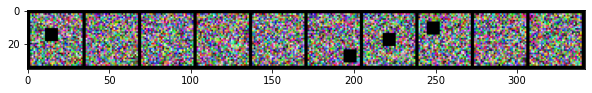

In [8]:
imshow(torchvision.utils.make_grid(images1,nrow=10))

### 4.3.5 커스텀 데이터와 파이토치 제공 전처리 사용하기

In [9]:
# torchvision.transforms에서 제공하는 전처리 기술을 사용한다.
# torchvision.transforms은 입력 이미지가 일반적으로 PILImage 타입이나 텐서일 경우에 동작한다.
# 현재 데이터는 넘파이 배열이다. 따라서 텐서 변환 후 tr.ToPILImage()을 이용하여 PILImage 타입으로 만들어 준다.
# __call__을 이용한 기본 구조는 동일하다.

class MyTransform:
    
    def __call__(self, sample):
        inputs, labels = sample
        inputs = torch.FloatTensor(inputs)
        inputs = inputs.permute(2,0,1)
        labels = torch.FloatTensor(labels)

        transf = tr.Compose([tr.ToPILImage(), tr.Resize(128), tr.ToTensor()])
        final_output = transf(inputs)      
        
        return final_output, labels  

In [10]:
dataset2 = MyDataset(train_images,train_labels, transform=MyTransform())
train_loader2 = DataLoader(dataset2, batch_size=10, shuffle=True)

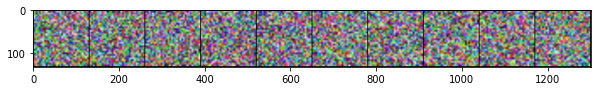

torch.Size([10, 3, 128, 128])


In [11]:
images2, labels2 = iter(train_loader2).next()
imshow(torchvision.utils.make_grid(images2,nrow=10))
print(images2.size()) # 배치 및 이미지 크기 확인

### 4.3.6 커스텀 데이터와 파이토치 제공 전처리 사용하기

In [12]:
class CutOut:
    
    def __init__(self, ratio=.5):
        self.ratio = int(1/ratio)
           
    def __call__(self, inputs):

        active = int(np.random.randint(0, self.ratio, 1))
        
        if active == 0:
            _, w, h = inputs.size()
            min_len = min(w, h)
            box_size = int(min_len//4)
            idx = int(np.random.randint(0, min_len-box_size, 1))
            inputs[:,idx:idx+box_size,idx:idx+box_size] = 0
        
        return inputs

In [13]:
# 3.3에서 사용한 양식을 그대로 사용하되 전처리 작업을 할 수 있도록 transform을 추가한다. 
class MyDataset(Dataset):
    
    def __init__(self, x_data, y_data, transform=None):
        
        self.x_data = x_data # 넘파이 배열이 들어온다.
        self.y_data = y_data # 넘파이 배열이 들어온다.
        self.transform = transform
        self.len = len(y_data)
        self.tensor = ToTensor()
    
    def __getitem__(self, index):
        sample = self.x_data[index], self.y_data[index]
        
        if self.transform:
            sample = self.transform(sample) #self.transform이 None이 아니라면 전처리를 작업한다.
        else:
            sample = self.tensor(sample)
        
        return sample
    
    def __len__(self):
        return self.len       

In [14]:
class MyTransform:
    
    def __call__(self, sample):
        inputs, labels = sample
        inputs = torch.FloatTensor(inputs)
        inputs = inputs.permute(2,0,1)
        labels = torch.FloatTensor(labels)

        transf = tr.Compose([tr.ToPILImage(), tr.Resize(128), tr.ToTensor(), CutOut()])
        final_output = transf(inputs)      
        
        return final_output, labels  

#### 전처리 적용

In [15]:
dataset3 = MyDataset(train_images,train_labels, transform=MyTransform())
train_loader3 = DataLoader(dataset3, batch_size=10, shuffle=True)

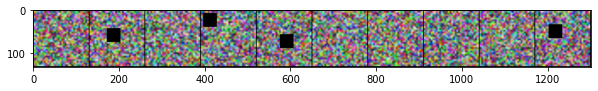

torch.Size([10, 3, 128, 128])


In [16]:
images3, labels3 = iter(train_loader3).next()
imshow(torchvision.utils.make_grid(images3,nrow=10))
print(images3.size()) # 배치 및 이미지 크기 확인

#### 전처리 미적용

In [17]:
dataset3 = MyDataset(train_images,train_labels)
train_loader3 = DataLoader(dataset3, batch_size=10, shuffle=True)

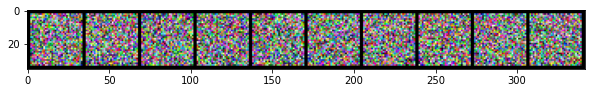

torch.Size([10, 3, 32, 32])


In [18]:
images3, labels3 = iter(train_loader3).next()
imshow(torchvision.utils.make_grid(images3,nrow=10))
print(images3.size()) # 배치 및 이미지 크기 확인

#### CIFAR100 데이터와 커스텀 전처리 사용

In [19]:
transf = tr.Compose([tr.Resize(128), tr.ToTensor(), CutOut()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transf)

Files already downloaded and verified


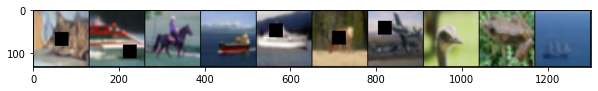

torch.Size([10, 3, 128, 128])


In [20]:
trainloader = DataLoader(trainset, batch_size=10, shuffle=True)
images, labels = iter(trainloader).next()
imshow(torchvision.utils.make_grid(images,nrow=10))
print(images.size()) # 배치 및 이미지 크기 확인